In [845]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score , mean_squared_error
from scipy.stats import f_oneway
import seaborn as sns 
%matplotlib inline

### Buisness understanding 

AirBnB is a platform that allows users to offer short term rental stays. It is a common site used for booking vacations. The data set can be used to answer questions for the host, the user and the buisness. 
In my analysis I will focus on the price of listings. 
This will provide insights to future hosts to allow them to offer the best prices for profits. 
It will also give guidence to users, of the range of prices to expect. 

#### In my Analysis I will consider the questions : 
1) Which features of the seatle dataset provide the most information for predicting the price ? 

2) How can we predict the price of an air bnb using numeric and categoric columns in the data set ? 

3) What neighbourhood in seattle is the cheapest to rent a listing ?

### Data Understaning 

#### A) Load the data 

In [846]:
#Load in data 
df_listings = pd.read_csv('./Seatle/listings.csv')

In [847]:
df_listings.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89


In [848]:
df_listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 92 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                3818 non-null   int64  
 1   listing_url                       3818 non-null   object 
 2   scrape_id                         3818 non-null   int64  
 3   last_scraped                      3818 non-null   object 
 4   name                              3818 non-null   object 
 5   summary                           3641 non-null   object 
 6   space                             3249 non-null   object 
 7   description                       3818 non-null   object 
 8   experiences_offered               3818 non-null   object 
 9   neighborhood_overview             2786 non-null   object 
 10  notes                             2212 non-null   object 
 11  transit                           2884 non-null   object 
 12  thumbn

Printing the head and the information of the variables shows some variables need to be cleaned before they can be used : 
- Price features and responce rate features are objects and need to be cleaned and converted to integers or floats. 
- The ammenities column contains useful information about the propeties of the listings but need to be cleaned 
- NaN values in the dataset need to be handled. 

In [849]:
df_listings['price'].describe()

count        3818
unique        273
top       $150.00
freq          162
Name: price, dtype: object

## Q1. Which features of the seatle dataset provide the most information for predicting the price ? 

To answer this question I follow a process of : 
- Data Understanding
- Data preparation 
    - Handling NaN values
    - Cleaning data columns 
    - Handling of categoric data 
- Data Modelling 
    - Analysis of numeric variables and their relationship to price. 
    - Analysis of categoric variables and their relationship to price. 
- Deploy 
    - Selection of features for the model. 

### Data Preperation 

In [850]:
#Drop columns with all NaN values as we do not loose any information. 
df_listings = df_listings.dropna(how='all', axis=1)

In [851]:
#Price is the predictor variable so we drop all rows with a missing price value. 
df_listings = df_listings.dropna(subset=['price'], axis=0)

In [852]:
#Clean the price column and convert it to a float data type. 
for col in ["price","monthly_price","weekly_price","cleaning_fee","security_deposit","extra_people"]:
        df_listings[col] = df_listings[col].map(lambda p : p.replace('$','').replace(',',''),na_action = 'ignore')
        df_listings[col] = df_listings[col].astype(float)

In [853]:
# Clean Columns with a % symbol and convert from an object to a float data type.  
for col in ["host_response_rate", "host_acceptance_rate"]:
    df_listings[col] = df_listings[col].map(lambda p : p.replace('%',''), na_action='ignore')
    df_listings[col] = df_listings[col].astype(float)

In [854]:
#Clean date data columns to float days 
for col in ["host_since","last_scraped","first_review","last_review"]: 
     df_listings[col] = pd.to_datetime(df_listings[col])

From the results of analysis the colums. Columns are dropped that don't provide useful information : 
- URL's as these are distinct and not related to the price 
- Location variables that contain overlapping information. Neighbourhood group cleaned chosen as a location variable. 
-Columns that can not be easily used to extract information for example the summary column which is unique for all listings in the dataset. 

In [855]:
#Drop columns that don't provide information 
df_listings = df_listings.drop(['listing_url', 'medium_url', 'picture_url',  
             'xl_picture_url', 'host_url', 'host_thumbnail_url', 'host_picture_url', 
             'city','state','country','country_code','market','requires_license','experiences_offered',
            'first_review', 'last_review','calendar_last_scraped',
       'calendar_updated', 'scrape_id', 'last_scraped', 'space',  'thumbnail_url',
        'neighborhood_overview', 'host_listings_count', 'is_location_exact', 
       'host_total_listings_count','smart_location','host_id','name','summary','description','notes','neighbourhood','zipcode'],axis = 1)

### Data Modelling - Numeric Features Analysis 

In [856]:
#Create a subset of the dataframe that holds only the numeric columns 
num_cols = df_listings._get_numeric_data().columns;
numeric_df = df_listings[num_cols]

Map the correlation between the numeric columns in the dataset and the price using seaborns heat map functionality. 

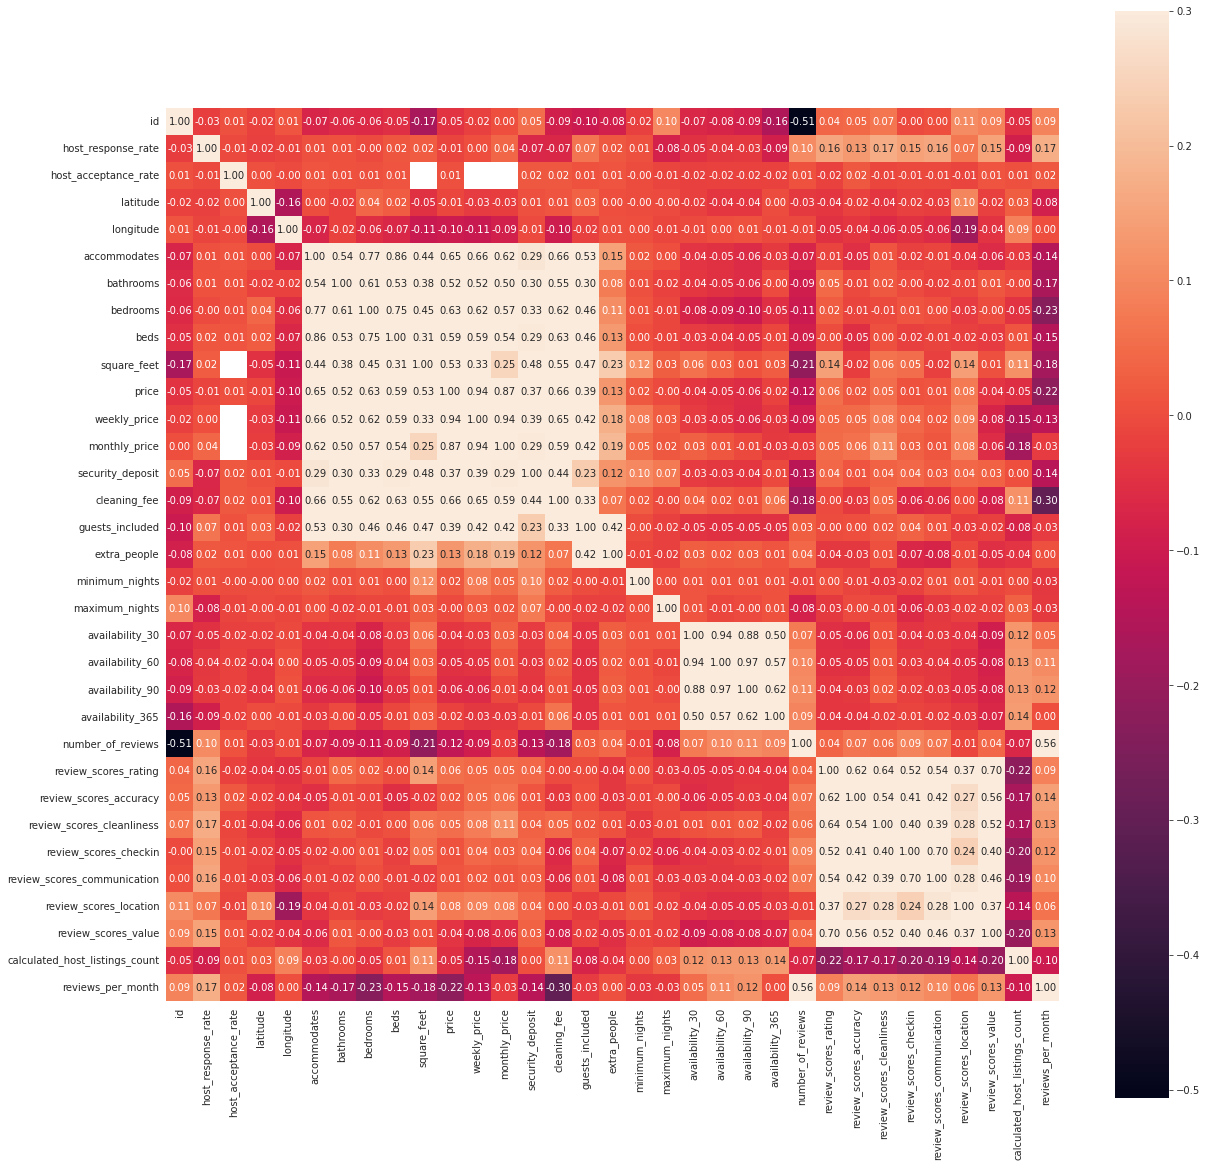

In [857]:
#Create a heat map for the numeric columns 
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(20, 20))
    ax = sns.heatmap(numeric_df.corr(),annot = True, vmax=.3, square=True, fmt = '.2f')

In [858]:
numeric_df.corr()['price'].sort_values(ascending = False )

price                             1.000000
weekly_price                      0.937861
monthly_price                     0.873450
cleaning_fee                      0.656938
accommodates                      0.652218
bedrooms                          0.627720
beds                              0.589525
square_feet                       0.531752
bathrooms                         0.516424
guests_included                   0.392875
security_deposit                  0.373195
extra_people                      0.127961
review_scores_location            0.075069
review_scores_rating              0.055551
review_scores_cleanliness         0.054357
review_scores_accuracy            0.019026
minimum_nights                    0.017297
review_scores_communication       0.012990
review_scores_checkin             0.007877
host_acceptance_rate              0.005900
maximum_nights                   -0.003336
latitude                         -0.008904
host_response_rate               -0.014071
availabilit

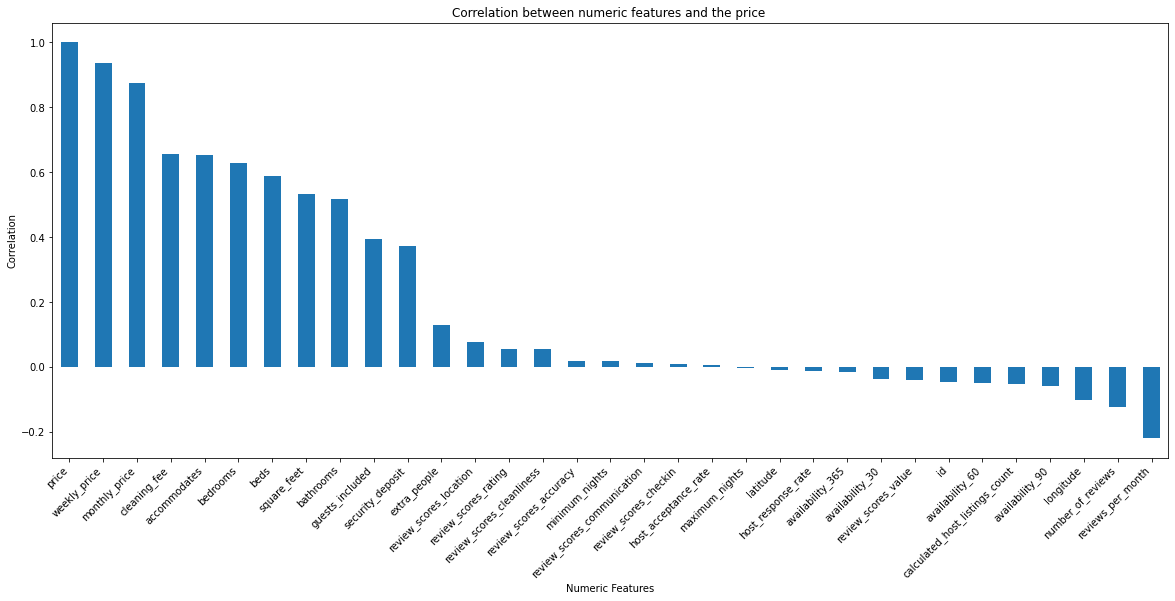

In [859]:
def correlation_plot(df , title , xlabel , ylabel): 
    '''
    INPUT: 
    
    Method to produce scatter plots to map the correlation between the price and the columns in a dataframe 
    df: The dataframe that contains the collumns to build the plot 
    
    title : The title of the scatter plot
    xlabel : The label of the x axis 
    y label : The label of the y axis 
    
    OUTPUT: 
    When called the method produces a scatter plot. 
    '''
    fig,ax = plt.subplots()
    df.corr()['price'].sort_values(ascending=False).plot.bar()
    labels = ax.get_xticklabels()
    plt.setp(labels,rotation = 45 , horizontalalignment = 'right')

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    fig.set_figwidth(20)
    fig.set_figheight(8)
    
correlation_plot(numeric_df,'Correlation between numeric features and the price ','Numeric Features', 'Correlation')

The heat map shows : 
- Other price variables have the highest correlation with the price. 
- Features of the property have a high correlation. The number of bedrooms, bathrooms, size. 
- High negitive correlations were recorded for the number of reviews and the reviews per month. 

However to know the impact of these variables we need to consider the amount of missing data. 
Futher data understanding comes from analysis the number of NaN values. 

In [860]:
numeric_df.isnull().mean().sort_values()

id                                0.000000
number_of_reviews                 0.000000
availability_365                  0.000000
availability_90                   0.000000
availability_60                   0.000000
availability_30                   0.000000
maximum_nights                    0.000000
minimum_nights                    0.000000
calculated_host_listings_count    0.000000
guests_included                   0.000000
extra_people                      0.000000
latitude                          0.000000
price                             0.000000
longitude                         0.000000
accommodates                      0.000000
beds                              0.000262
bedrooms                          0.001572
bathrooms                         0.004191
host_response_rate                0.136983
reviews_per_month                 0.164222
review_scores_rating              0.169460
review_scores_communication       0.170508
review_scores_cleanliness         0.171032
review_scor

Imputing the columns with the mean is the default method to fill NaN values. 
It is appropriate as we are using numeric data where the mean can be easily derived. 
In future analysis I would expand on this method and test each column individually with alternative imputation methods, to mitigate the impact of NaN values on the resulting model. 
The method chosen here allows us to get an idea of the importance and correlation of each feature in relation to the price and therefore is appropriate for the aim of my analysis and question. 

In [861]:
# Method to fill the numeric null values with the mean 
def fillMean(df): 
    '''
    Method to impute the mean for numeric columns. 
    It calculates the mean for each column in the dataframe and imputes the mean value where the existing value is NaN 
    df: The dataframe to be imputed by the mean.
    
    OUTPUT: 
    Dataframe: 
     - Where NaN values have been imputed with the mean of each column 
    '''
    # Mean function
    fill_mean = lambda col: col.fillna(col.mean(),inplace = True)
    
    # Fill the mean
    df = df.apply(fill_mean, axis=0)
    return df 

In [862]:
fillMean(numeric_df)

id                                None
host_response_rate                None
host_acceptance_rate              None
latitude                          None
longitude                         None
accommodates                      None
bathrooms                         None
bedrooms                          None
beds                              None
square_feet                       None
price                             None
weekly_price                      None
monthly_price                     None
security_deposit                  None
cleaning_fee                      None
guests_included                   None
extra_people                      None
minimum_nights                    None
maximum_nights                    None
availability_30                   None
availability_60                   None
availability_90                   None
availability_365                  None
number_of_reviews                 None
review_scores_rating              None
review_scores_accuracy   

In [863]:
numeric_df.corr()['price'].sort_values(ascending = False) 

price                             1.000000
accommodates                      0.652218
bedrooms                          0.627596
weekly_price                      0.626361
beds                              0.589306
cleaning_fee                      0.583274
bathrooms                         0.516017
monthly_price                     0.495664
guests_included                   0.392875
security_deposit                  0.294389
extra_people                      0.127961
square_feet                       0.084090
review_scores_location            0.068178
review_scores_rating              0.050488
review_scores_cleanliness         0.049385
minimum_nights                    0.017297
review_scores_accuracy            0.017278
review_scores_communication       0.011802
review_scores_checkin             0.007154
host_acceptance_rate              0.004848
maximum_nights                   -0.003336
latitude                         -0.008904
host_response_rate               -0.012718
availabilit

In [864]:
numeric_df=numeric_df.loc[:,(numeric_df.isnull().mean() < 0.50)]

After filling the columns with the mean, the correlatation for the columns is diluted.
For example after imputing the mean for the weekly_price column, the correlation to the price is diluted from 97% to 62%, therefore for predicting the price I have chosen to include features with less the 0.5 % null values.  

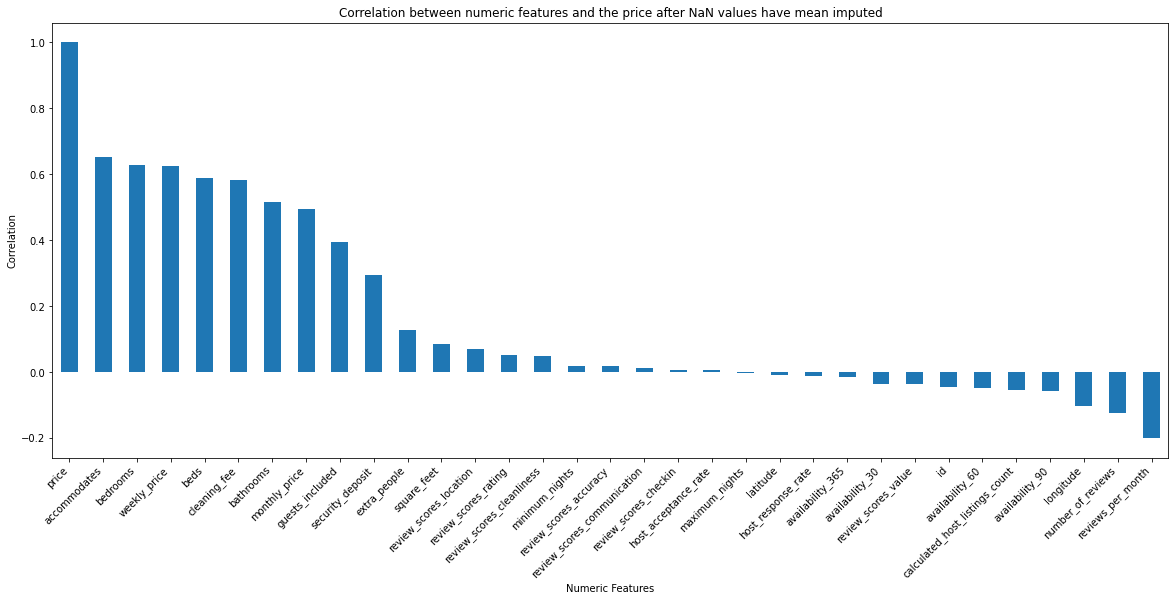

In [865]:
correlation_plot(numeric_df, 'Correlation between numeric features and the price after NaN values have mean imputed' , 'Numeric Features', 'Correlation')

Based on the results of the correlation to the price and the proportion of null values the features selected for the model are : 
- Values with a high positive correlation to the price 
    - accomodates 
    -bedrooms 
    -weekly_price
    -beds
    -cleaning_fee 
    -bathrooms
    -guests_included 
    -security deposit 
    -extra_people 
- Values with a high negitive correlation to the price 
    - reviews_per_month 
    -number of reviews 
    
    
Values with less than a 10% positive or negitive correlation to the price were removed as features. 

In [866]:
numeric_df = numeric_df[[
        'longitude', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'price',
       'guests_included', 'extra_people', 'reviews_per_month', 'number_of_reviews',
       'cleaning_fee']]

### Data Modelling - Categoric Feature Analysis 

Data understanding 

In [867]:
df_listings.size

217626

In [868]:
#Create a subset of the dataframe containing only the categorical columns 
cat_df = df_listings.select_dtypes(include=['object'])
cat_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 23 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   transit                           2884 non-null   object
 1   host_name                         3816 non-null   object
 2   host_location                     3810 non-null   object
 3   host_about                        2959 non-null   object
 4   host_response_time                3295 non-null   object
 5   host_is_superhost                 3816 non-null   object
 6   host_neighbourhood                3518 non-null   object
 7   host_verifications                3818 non-null   object
 8   host_has_profile_pic              3816 non-null   object
 9   host_identity_verified            3816 non-null   object
 10  street                            3818 non-null   object
 11  neighbourhood_cleansed            3818 non-null   object
 12  neighbourhood_group_

If you have a large number of categorical variables or categorical variables with a large number of levels, but not a large sample size, it is difficult to estimate the impact of these variables on the price. 


In [894]:
#Print number of distinct values in each category
for col in cat_df.columns:
    print(col,' ' , len(cat_df[col].unique()))

host_response_time_within a day   2
host_response_time_within a few hours   2
host_response_time_within an hour   2
host_has_profile_pic_t   2
neighbourhood_group_cleansed_Beacon Hill   2
neighbourhood_group_cleansed_Capitol Hill   2
neighbourhood_group_cleansed_Cascade   2
neighbourhood_group_cleansed_Central Area   2
neighbourhood_group_cleansed_Delridge   2
neighbourhood_group_cleansed_Downtown   2
neighbourhood_group_cleansed_Interbay   2
neighbourhood_group_cleansed_Lake City   2
neighbourhood_group_cleansed_Magnolia   2
neighbourhood_group_cleansed_Northgate   2
neighbourhood_group_cleansed_Other neighborhoods   2
neighbourhood_group_cleansed_Queen Anne   2
neighbourhood_group_cleansed_Rainier Valley   2
neighbourhood_group_cleansed_Seward Park   2
neighbourhood_group_cleansed_University District   2
neighbourhood_group_cleansed_West Seattle   2
property_type_Bed & Breakfast   2
property_type_Boat   2
property_type_Bungalow   2
property_type_Cabin   2
property_type_Camper/RV   2


Select categoric features : 
- Features with only one value do not add any information so are dropped 
- The data set has only 3818 rows. Features with a high cardinality are dropped to prevent overfitting. 

In [870]:
cat_df=cat_df.loc[:,(cat_df.nunique()<80) & (cat_df.nunique()> 1)]
cat_df.columns

Index(['host_response_time', 'host_is_superhost', 'host_has_profile_pic',
       'host_identity_verified', 'neighbourhood_group_cleansed',
       'property_type', 'room_type', 'bed_type', 'instant_bookable',
       'cancellation_policy', 'require_guest_profile_picture',
       'require_guest_phone_verification'],
      dtype='object')

In [871]:
cat_df.isnull().mean().sort_values()

neighbourhood_group_cleansed        0.000000
room_type                           0.000000
bed_type                            0.000000
instant_bookable                    0.000000
cancellation_policy                 0.000000
require_guest_profile_picture       0.000000
require_guest_phone_verification    0.000000
property_type                       0.000262
host_is_superhost                   0.000524
host_has_profile_pic                0.000524
host_identity_verified              0.000524
host_response_time                  0.136983
dtype: float64

The categoric columns selected have a low number of null values so we do not need to add a NaN dummy column for the values in the dataset. 

In [872]:
box_plot_df = pd.concat([numeric_df['price'],cat_df],axis =1 )

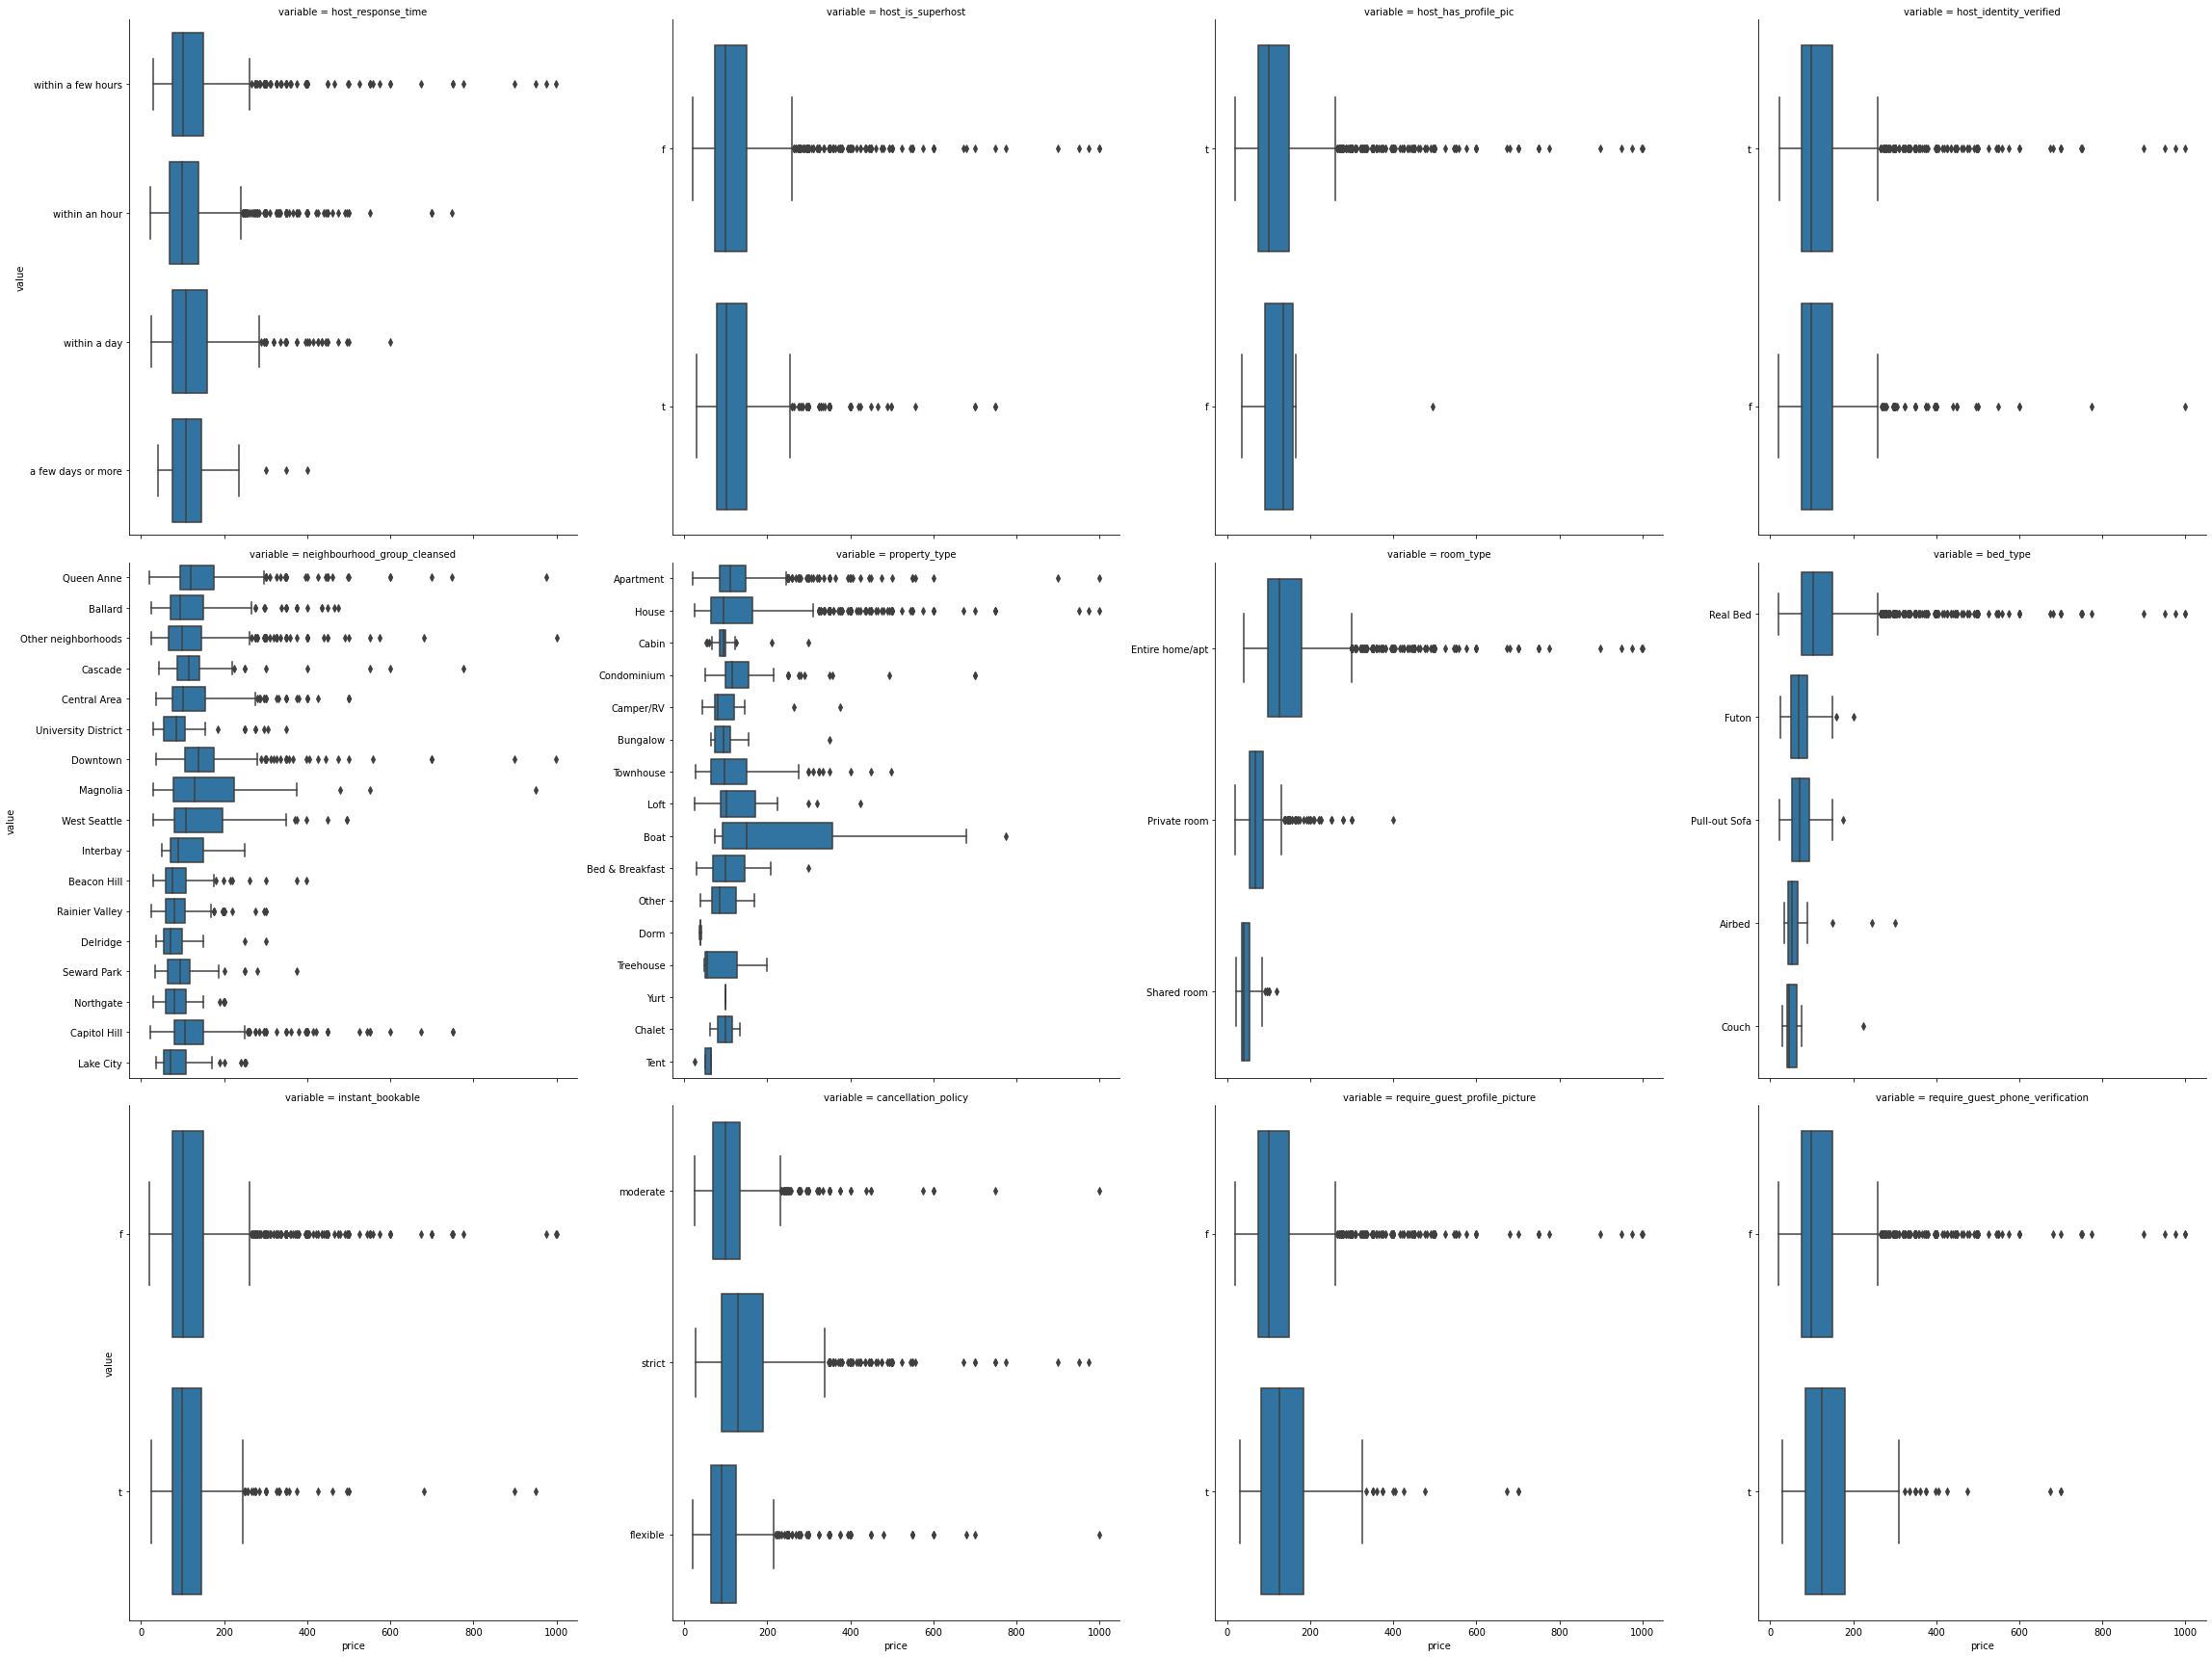

In [873]:
df = box_plot_df.melt(id_vars=['price'])
cols = cat_df
grid = sns.axisgrid.FacetGrid(df[df.variable.isin(cols)], col='variable', sharey=False, height = 8 , col_wrap = 4)
grid.map(sns.boxplot, 'price','value', order = list(set(df['price'])).sort())

In [ ]:
Box plots were chosen as they allow you to identify and distinguish patterns between groups of data. This is appropropriate for our question. Columns with a large number of variation between the subcategories in relation to the price are likely to be more useful for prediction. 

The box plots show the distribution of prices for the categoric data in the dataset. 
- Host_is_superhost , host_identity_verified and instant_bookable are dropped from the categoric dataset as the distribution of features related to the price is allmost identical for all categories. 

In [874]:
cat_df = cat_df.drop(['host_identity_verified','instant_bookable','host_is_superhost'], axis=1)
cat_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 9 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   host_response_time                3295 non-null   object
 1   host_has_profile_pic              3816 non-null   object
 2   neighbourhood_group_cleansed      3818 non-null   object
 3   property_type                     3817 non-null   object
 4   room_type                         3818 non-null   object
 5   bed_type                          3818 non-null   object
 6   cancellation_policy               3818 non-null   object
 7   require_guest_profile_picture     3818 non-null   object
 8   require_guest_phone_verification  3818 non-null   object
dtypes: object(9)
memory usage: 268.6+ KB


Data Preperation 

Dummy dataframe created. The method creates a new column for each sub category and assigns 0 and 1 values to identify if a feature was present for each listing. 
This is because it is a simple technique, allowing me to quickly explore the impact of the features. 
Is effective with columns with a low cardinality. In the analysis I have dropped columns with a large number of sub features. 

REFERENCE : This method utilises content and concepts taught in module 2 of the udacity data science nano degree

In [875]:
def create_dummy_df(df, categoric_cols, dummy_na):
    '''
    Method that creates a dummy dataframe for the categoric columns. 
    
    INPUT:
    df -  Dataframe with categorical variables you want to dummy
    categoric_cols - String names for the categoric columns 
    dummy_na - Bool variable to assign if you want to dummy the NaN values 
    
    OUTPUT:
    df - a new dataframe that has the following characteristics:
            -  removes all the original columns in categoric_cols
            - Creates a dummy column for each of the categoric columnns 
            - If dummy_na is True a dummy column is created for the NaN values 
            - '_' prefix used with the column name 
    '''
    for col in  df:
        try:
            # for each cat add dummy var, drop original column
            df = pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col], prefix=col, prefix_sep='_', drop_first=True, dummy_na=dummy_na)], axis=1)
        except:
            continue
    return df

In [876]:
cat_df = create_dummy_df(cat_df,cat_df.columns,False)  

In [877]:
cat_df.head()

,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour,host_has_profile_pic_t,neighbourhood_group_cleansed_Beacon Hill,neighbourhood_group_cleansed_Capitol Hill,neighbourhood_group_cleansed_Cascade,neighbourhood_group_cleansed_Central Area,neighbourhood_group_cleansed_Delridge,neighbourhood_group_cleansed_Downtown,...,room_type_Private room,room_type_Shared room,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,cancellation_policy_moderate,cancellation_policy_strict,require_guest_profile_picture_t,require_guest_phone_verification_t
0,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0
1,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,1,1
2,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0


In [878]:
dummy_df = pd.concat([cat_df, numeric_df['price']],axis = 1)

In [879]:
dummy_df.corr()['price'].sort_values(ascending=False)

price                                               1.000000
cancellation_policy_strict                          0.226632
bed_type_Real Bed                                   0.126372
neighbourhood_group_cleansed_Downtown               0.117590
neighbourhood_group_cleansed_Queen Anne             0.093789
property_type_Boat                                  0.078404
neighbourhood_group_cleansed_Magnolia               0.070174
require_guest_profile_picture_t                     0.063297
require_guest_phone_verification_t                  0.057599
property_type_House                                 0.044204
property_type_Condominium                           0.040059
host_response_time_within a few hours               0.037770
neighbourhood_group_cleansed_West Seattle           0.035146
host_response_time_within a day                     0.023105
neighbourhood_group_cleansed_Cascade                0.020758
neighbourhood_group_cleansed_Capitol Hill           0.012109
property_type_Loft      

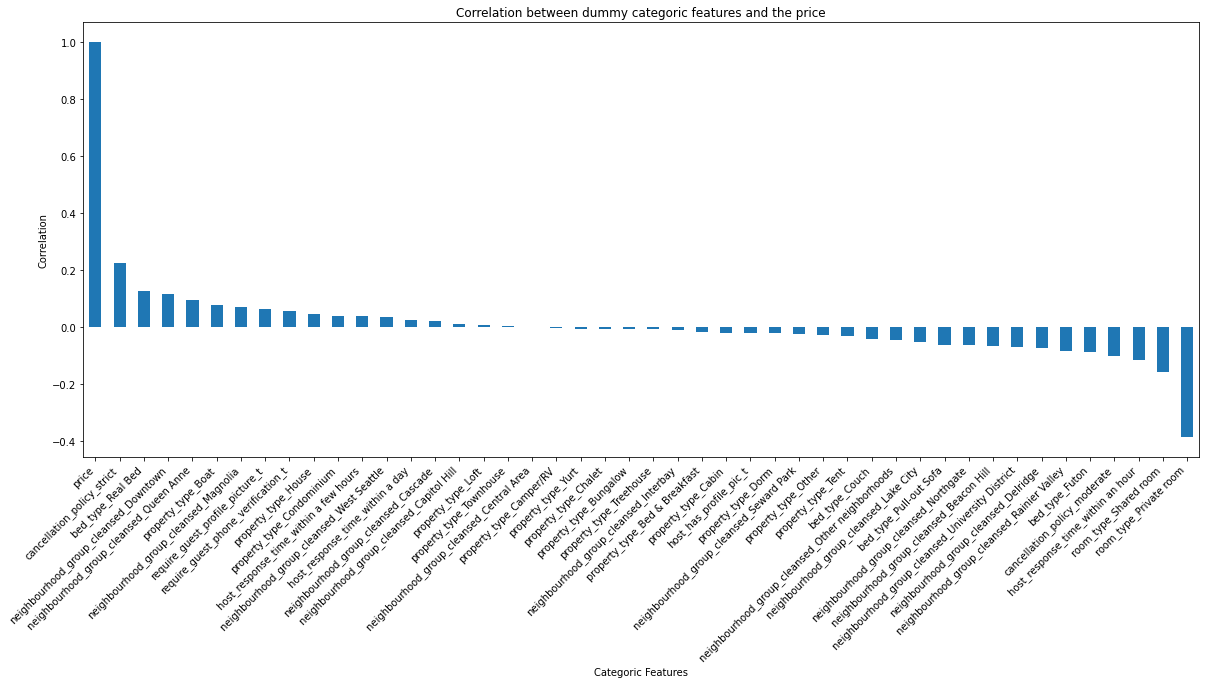

In [880]:
correlation_plot(dummy_df, 'Correlation between dummy categoric features and the price' , 'Categoric Features', 'Correlation')

The bar chart shows that the dummy categoric data has a smaller relationship to the price, than the numeric data. 
- The highest positive correlations : 
    - cancellation_policy_strict     
    - bed_type_Real Bed 
    - neighbourhood_group_cleansed_Downtown 
    - neighbourhood_group_cleaned_Queen Anne
- Highest negitive correlations 
    - Room_type_private_room 
    - Room_type_shared_room

The Ammenities columns was identified in data understanding to contain useful data but to be messy: 

Clean and analyse the amenties columns 

Reference : Inspiration for this process came from Kaggle projects linked in the readme. 

In [881]:
#Remove special characters from the ammenities column 
for col in ["amenities"]:
        df_listings[col] = df_listings[col].map(lambda p : p.replace('{','').replace('}','').replace('"',''),na_action = 'ignore')
cleaned_ammenities = []

#A comma distinguises the features - Split where there is a comma. 
for value in df_listings.amenities: 
    cleaned_ammenities.extend(value.split(','))
cleaned_ammenities = pd.unique(cleaned_ammenities)

#Create an empty matrix to hold the correct number of rows and columns for the subcategories 
ammenities_dummy = pd.DataFrame(np.zeros((len(df_listings),len(cleaned_ammenities))),columns=cleaned_ammenities)

#Itterate and assign a value 1 if the sub-category exists for a listing. 
for i,value in enumerate(df_listings.amenities):
    index = ammenities_dummy.columns.get_indexer(value.split(','))
    ammenities_dummy.iloc[i,index]=1
    
ammenities_dummy 

,TV,Cable TV,Internet,Wireless Internet,Air Conditioning,Kitchen,Heating,Family/Kid Friendly,Washer,Dryer,...,Elevator in Building,Lock on Bedroom Door,Wheelchair Accessible,Gym,,Pool,Smoking Allowed,Other pet(s),Doorman,Washer / Dryer
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3813,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3814,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3815,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3816,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [882]:
ammenities_dummy = pd.concat([ammenities_dummy , df_listings['price'] ],axis = 1)

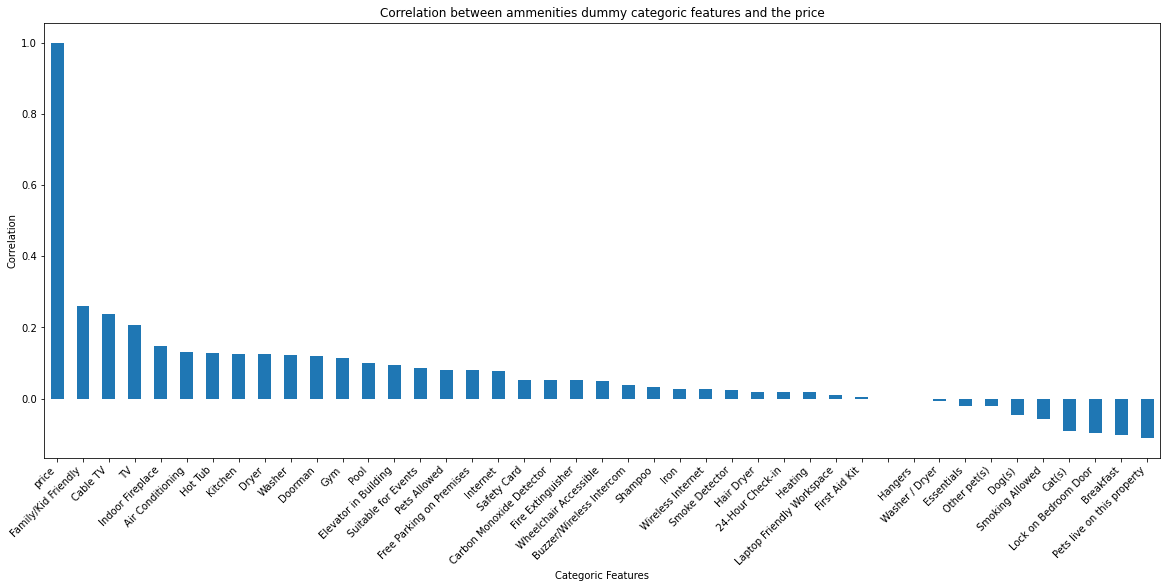

In [883]:
correlation_plot(ammenities_dummy, 'Correlation between ammenities dummy categoric features and the price' , 'Categoric Features', 'Correlation')

A significant number of sub-categories of the ammenities column had a relationship with the price. 
The ammenities column is added as an additional feature to be used to build the model. 

In [884]:
ammenities_dummy = ammenities_dummy.drop('price',axis = 1)

### Selection of features for model 

In [885]:
dataframe = pd.concat([numeric_df,cat_df,ammenities_dummy] , axis = 1)
dataframe.head()

,longitude,accommodates,bathrooms,bedrooms,beds,price,guests_included,extra_people,reviews_per_month,number_of_reviews,...,Elevator in Building,Lock on Bedroom Door,Wheelchair Accessible,Gym,,Pool,Smoking Allowed,Other pet(s),Doorman,Washer / Dryer
0,-122.371025,4,1.0,1.0,1.0,85.0,2,5.0,4.070000,207,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-122.365666,4,1.0,1.0,1.0,150.0,1,0.0,1.480000,43,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-122.369483,11,4.5,5.0,7.0,975.0,10,25.0,1.150000,20,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-122.369279,3,1.0,0.0,2.0,100.0,1,0.0,2.078919,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-122.372471,6,2.0,3.0,3.0,450.0,6,15.0,0.890000,38,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [886]:
dataframe.columns

Index(['longitude', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'price',
       'guests_included', 'extra_people', 'reviews_per_month',
       'number_of_reviews', 'cleaning_fee', 'host_response_time_within a day',
       'host_response_time_within a few hours',
       'host_response_time_within an hour', 'host_has_profile_pic_t',
       'neighbourhood_group_cleansed_Beacon Hill',
       'neighbourhood_group_cleansed_Capitol Hill',
       'neighbourhood_group_cleansed_Cascade',
       'neighbourhood_group_cleansed_Central Area',
       'neighbourhood_group_cleansed_Delridge',
       'neighbourhood_group_cleansed_Downtown',
       'neighbourhood_group_cleansed_Interbay',
       'neighbourhood_group_cleansed_Lake City',
       'neighbourhood_group_cleansed_Magnolia',
       'neighbourhood_group_cleansed_Northgate',
       'neighbourhood_group_cleansed_Other neighborhoods',
       'neighbourhood_group_cleansed_Queen Anne',
       'neighbourhood_group_cleansed_Rainier Valley',
       

## 2) Can we train a classifier to predict the price ? 

In [887]:
dataframe.describe()

,longitude,accommodates,bathrooms,bedrooms,beds,price,guests_included,extra_people,reviews_per_month,number_of_reviews,...,Elevator in Building,Lock on Bedroom Door,Wheelchair Accessible,Gym,,Pool,Smoking Allowed,Other pet(s),Doorman,Washer / Dryer
count,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,...,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000
mean,-122.333103,3.349398,1.259469,1.307712,1.735394,127.976166,1.672603,10.667627,2.078919,22.223415,...,0.205605,0.026192,0.078575,0.115767,0.011786,0.041645,0.021477,0.013358,0.022263,0.000524
std,0.031745,1.977599,0.589130,0.882700,1.139330,90.250022,1.311040,17.585922,1.665964,37.730892,...,0.404196,0.159726,0.269110,0.319988,0.107937,0.199802,0.144988,0.114816,0.147557,0.022884
min,-122.417219,1.000000,0.000000,0.000000,1.000000,20.000000,0.000000,0.000000,0.020000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-122.354320,2.000000,1.000000,1.000000,1.000000,75.000000,1.000000,0.000000,0.830000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-122.328874,3.000000,1.000000,1.000000,1.000000,100.000000,1.000000,0.000000,2.000000,9.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,-122.310800,4.000000,1.000000,2.000000,2.000000,150.000000,2.000000,20.000000,2.660000,26.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,-122.240607,16.000000,8.000000,7.000000,15.000000,1000.000000,15.000000,300.000000,12.150000,474.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Produce a linear regression model using the features selected in answering question one the process involves : 
- Prepare data (Completed in previous question, NaN Values and categoric data handled appropriately) 
- Split into explanatory and responce variables
- Use sklearn test train split to create testing and training datasets 
- Normalise the dataset. 
- Instantiate the linear regression model 
- Fit the linear regression model 
- Predict the linear regression model 
- Calcualate the R2_score and the mean_square_error 
- Plot the residuals 

##### Reference : This method is inspired by module 2 of the data science nano degree program 

In [888]:
def numeric_categoric_model(df, response_col, test_size=.3, rand_state=42):
    '''
    Method to train, test , predict and score a linear regression model 
    
    INPUT:
    df - a dataframe holding all the variables of interest
    response_col - a string holding the name of the column 
    test_size - a float between [0,1] - Holds the proportion of data you want to be in the test set 
    rand_state - an int that is provided as the random state for splitting the data into training and test. This ensures that another user produces the same result. 
    
    OUTPUT : 
    When called the method prints the R2 scores and MSE for the train and test data sets and produces a graph to visualise the residuals. 
    lm_model - The model is returned 
    X-train - The training set is returned to allow the coefficents to be calculated. 
    '''
    
    #Impute the mean for empty values in the dataframe 
    fillMean(dataframe)
    
    #Split into explanatory and response variables
    X = df.drop(response_col, axis=1)
    y = df[response_col]

    #Split into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=rand_state)

   #Prodcue a linear regression pipeline 
    # Normalise the data using StandardScaler 
    # Instantiate the linear Regression model 

    lm_model =  Pipeline(
        [('scaler', StandardScaler(with_mean = False)),
         ('model', LinearRegression()),
        ])

    lm_model.fit(X_train, y_train) #Fit

    #Predict using your model
    y_test_preds = lm_model.predict(X_test)
    y_train_preds = lm_model.predict(X_train)

    #Reference : This code is my own, however inspiration to plot the residuals came from Kaggle projects linked in the read me. 
    
    # Print the r2 and MSE scores 
    print('R-squared score')
    print('Training Data : %.3f' % r2_score(y_train, y_train_preds), 'Testing Data : %.3f' % r2_score(y_test, y_test_preds))
    print('Mean Squared Error :')
    print('Training Data: %.3f' % mean_squared_error(y_train, y_train_preds),'Testing Data : %.3f' % mean_squared_error(y_test, y_test_preds))

    #Print Model's Residuals
    fig,ax = plt.subplots()
    plt.scatter(y_train_preds,  y_train_preds - y_train,c='blue', marker='o', label='Training data')
    plt.scatter(y_test_preds,  y_test_preds - y_test, c='black', marker='x', label='Test data')
    plt.title('Scatter plot showing the residuals for the train and test sets')
    plt.xlabel('Predicted')
    plt.ylabel('Residual')
    fig.set_figwidth(10)
    fig.set_figheight(10)
    
    plt.legend(loc='lower left')
    plt.show()
    return lm_model , X_train 


R-squared score
Training Data : 0.616 Testing Data : 0.607
Mean Squared Error :
Training Data: 3056.184 Testing Data : 3368.455


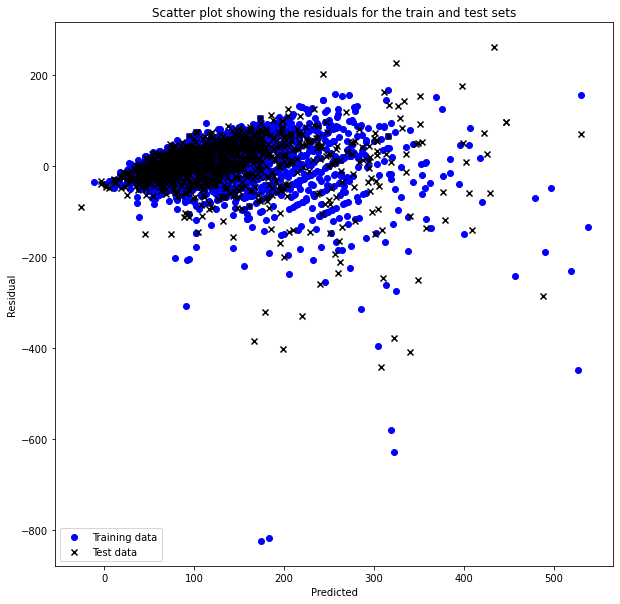

In [889]:
#Test function
lm_model , X_train = numeric_categoric_model(dataframe,'price')

The results show that using the selected features we can predict the price of an AirBnb in seatle based on the features of the listing. However the results give only an indication not a highly accurate prediction. 
The R2 score is approximately  60% this metric tells you how much of the variance can be explained by the independent variables in the model. The model also has high mean squared error values. 

In future analysis the error of the model could be minimised by implimenting a linear regression ridge and implementing cut off values for the number of features. 

The default penalty on coefficients using linear regression in sklearn is a ridge penalty. 
As we normalised the data, we can analyse the impact of each of the variables on the price by investigating the coefficents. 
The smaller the coefficent the smaller the impact on the responce column. 

##### Reference : This method is inspired by module 2 of the udacity data science nano degree program 

In [890]:
def coef_weights(lm_model,coefficients, X_train):
    '''
    Method to print the coefiicents of the model 
    
    INPUT:
    lm_model - The model for which you want to score the coefficents 
    coefficients - the coefficients of the linear model 
    X_train - the training data, so the column names can be used
    OUTPUT:
    coefs_df - a dataframe holding the coefficient
    
    Data frame holding the coefficents and the associated named variable 
    '''
    coefs_df = pd.DataFrame()
    coefs_df['Category'] = X_train.columns
    coefs_df['coefs'] = lm_model.named_steps['model'].coef_
    coefs_df['absolute_coefs'] = np.abs(lm_model.named_steps['model'].coef_)
    coefs_df = coefs_df.sort_values('absolute_coefs', ascending=False)
    return coefs_df

#Use the function
coef_df = coef_weights(lm_model , lm_model.named_steps['model'].coef_, X_train)

#Top Coefficents 
coef_df.head(20)

,Category,coefs,absolute_coefs
3,bedrooms,20.759401,20.759401
9,cleaning_fee,17.180965,17.180965
1,accommodates,17.003540,17.003540
45,room_type_Private room,-15.690481,15.690481
2,bathrooms,12.491774,12.491774
12,host_response_time_within an hour,-12.422104,12.422104
46,room_type_Shared room,-11.320408,11.320408
10,host_response_time_within a day,-9.362124,9.362124
19,neighbourhood_group_cleansed_Downtown,9.360551,9.360551
15,neighbourhood_group_cleansed_Capitol Hill,7.923530,7.923530


Numeric features had the highest impact on the price: 
- Bedrooms 
- Cleaning fee 
- accomodates 
 Of the categorical variables : 
- Room Type 
- Host responce time 
Had the highest impact on the price 
 

##  Q3 ) What Neighbourhood in seattle is the cheapest to rent a listing ?

In [891]:
df_listings['price'].describe()

count    3818.000000
mean      127.976166
std        90.250022
min        20.000000
25%        75.000000
50%       100.000000
75%       150.000000
max      1000.000000
Name: price, dtype: float64

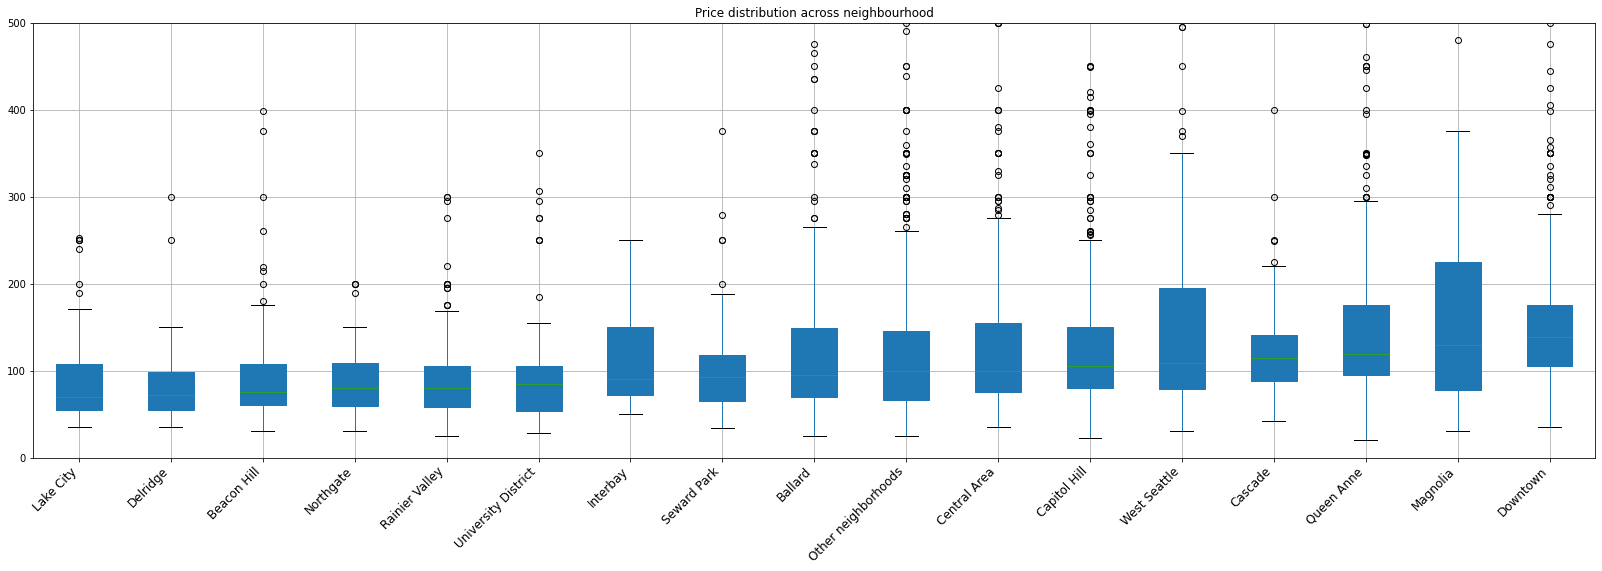

In [892]:
plt.figure(figsize=(28,8))
plt.title("Price distribution across neighbourhood")

#Data Preparation 
df_areas = df_listings[['price','neighbourhood_group_cleansed']]

def boxplot_sorted(df, by, column):
    '''
    A method to create a sorted box plot. 
    df : The dataframe for which you want to produce a box plot 
    by : The variable you want to group by to sort the values 
    column : The value you are measuring 
    ''' 
    df = pd.DataFrame({col:vals[column] for col, vals in df.groupby(by)})
    meds = df.median().sort_values()
    ax = df[meds.index].boxplot(rot=90,  patch_artist=True)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=12)
    plt.ylim([0,500])

boxplot_sorted(df_areas, by=["neighbourhood_group_cleansed"], column="price")

The box plots provide a visual answer to question 3. 
- Lake city and Delridge are the cheapest areas to rent in seattle. 
- Overlap in the distributions suggests that listings in the lower range of the spectrum can be found in many areas in the city. 
- The small standard deviation of £90 suggests most listings average around the median price


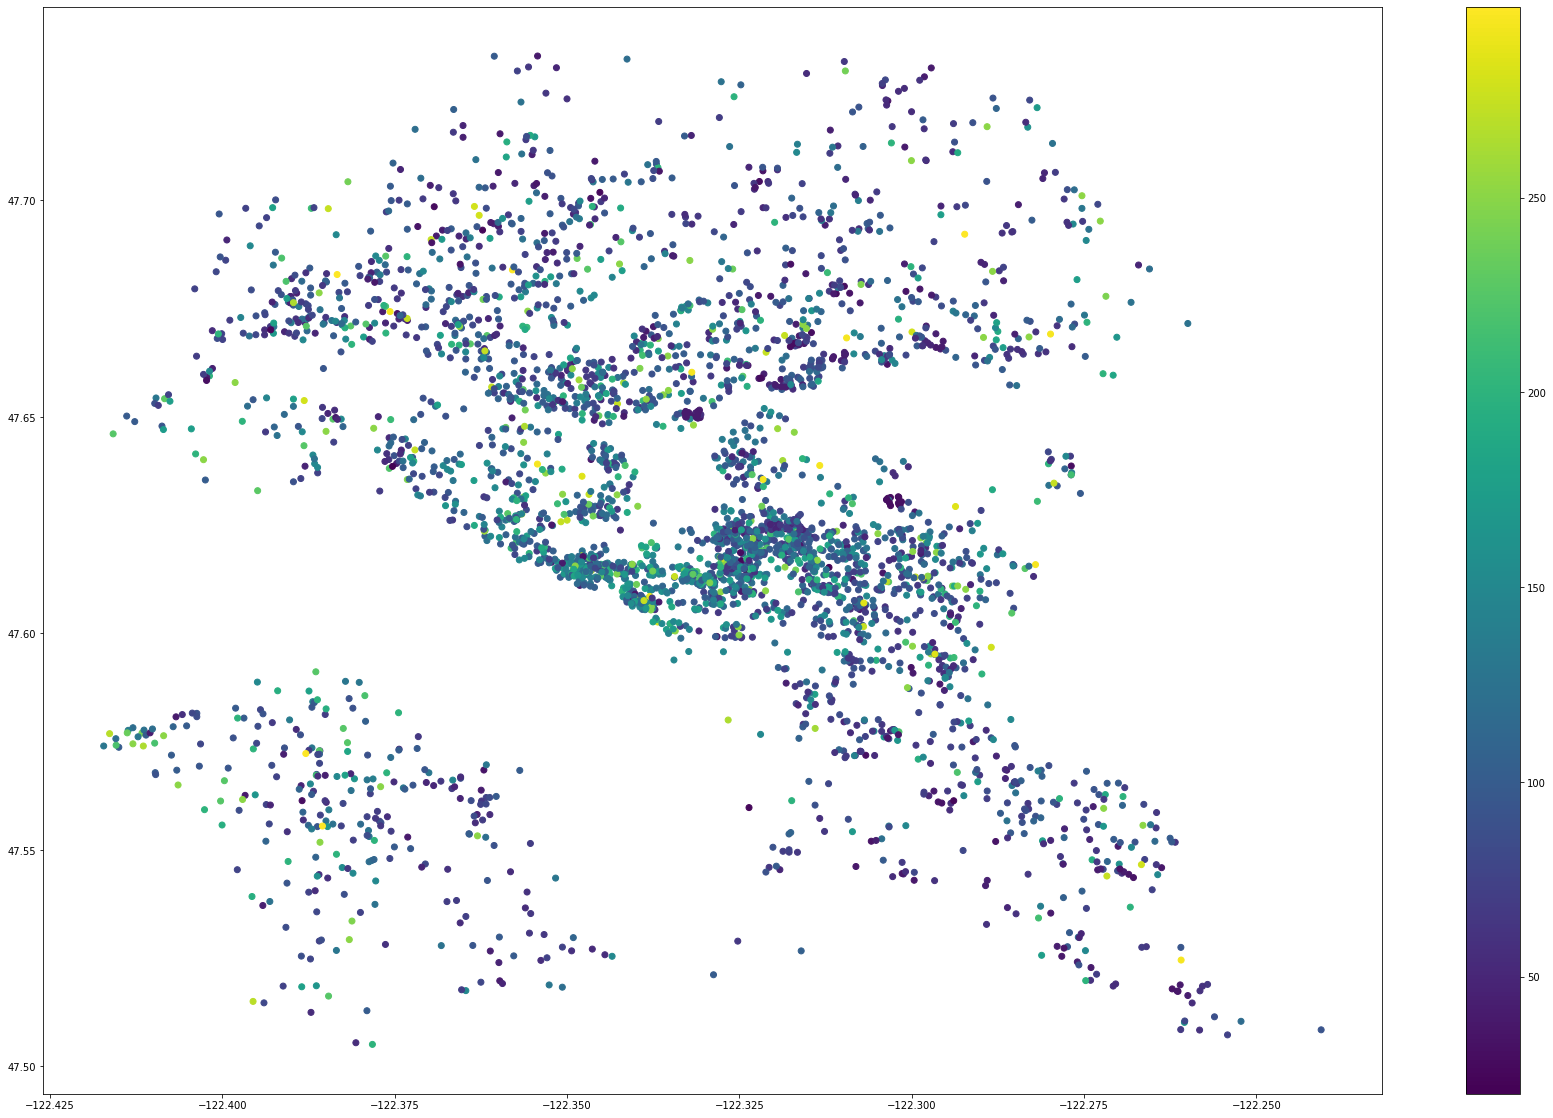

In [893]:
#The dataframe is subset to exclude outlier prices, so variation can be more easily observed. 
df_listings = df_listings[df_listings['price'] < 300]
plt.axisbelow: True

plt.rcParams['axes.grid'] = False
plt.figure(figsize=(30,20))
plt.scatter(x=df_listings['longitude'],y = df_listings['latitude'],c = df_listings.price, cmap = 'viridis')
plt.colorbar()
plt.show()

- Visualising the price in relation to the longitude and latitude shows that in all areas there are a range of prices available. 
- Where there are more listings the prices are more expensive. 
